### Libraries

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import dlc_bci as bci
from dlc_practical_prologue import *

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from scipy.signal import hilbert, chirp
from scipy import signal

import importlib
# customized libraries
import plot_lib as plib
import preprocess as prep


In [2]:
importlib.reload(bci)
importlib.reload(plib)
importlib.reload(prep)

<module 'preprocess' from '/home/cheng-chun-epfl/Dropbox/EPFL/course/MA2/deep learning/min-project/cheng-chun/preprocess.py'>

### Load dataset

In [3]:
# tr_input_org, tr_target = bci.load("bci", train=True, one_khz=True)
tr_input_org, tr_target_org = bci.load("bci", train=True, one_khz=False)
# te_input_org, te_target = bci.load("bci", train=False, one_khz=True)
te_input_org, te_target = bci.load("bci", train=False, one_khz=False)


tr_target_onehot = convert_to_one_hot_labels(tr_input_org, tr_target_org)
te_target_onehot = convert_to_one_hot_labels(te_input_org, te_target)

tr_target_onehot = Variable(tr_target_onehot)
te_target_onehot = Variable(te_target_onehot)

tr_target_org = Variable(tr_target_org)
te_target = Variable(te_target)

### Preprocessing - moving average / downsampling / DC blocker / DFT

In [4]:
importlib.reload(prep)
# moving average
N = 5
# downsampling
Nd = 4
# DC blocker
alpha = 0.9
# find peak
Np = 5
# FFT extraction
size = 20


tr_input = tr_input_org.clone()
te_input = te_input_org.clone()
tr_target = tr_target_org.clone()

# inc_size = 700
# tr_input, tr_target = prep.augment(tr_input, tr_target, inc_size)

# reserve_list = [0, 1, 4, 5, 7, 11, 15, 16, 19, 23, 26, 27]

# tr_input = prep.channel_used(tr_input, reserve_list)
# te_input = prep.channel_used(te_input, reserve_list)

# tr_input = channel_used(tr_input, reserve_list)

# tr_input = tr_input[:,:15,:]
# te_input = te_input[:,:15,:]

# peak detector
# tr_input = prep.peak_detector_filtering(tr_input, Np)
# te_input = prep.peak_detector_filtering(te_input, Np)

# low pass filtering
tr_input = prep.lowpass_filtering(tr_input, N)
te_input = prep.lowpass_filtering(te_input, N)

# downsampling
# tr_input = prep.downsampling_filtering(tr_input, Nd)
# te_input = prep.downsampling_filtering(te_input, Nd)


# dc block
# tr_input = dc_blocker_filtering(tr_input, alpha)
# te_input = dc_blocker_filtering(te_input, alpha)

# fft data generation
# tr_input = prep.fft_input_generation(tr_input, size, with_phase=False)
# te_input = prep.fft_input_generation(te_input, size, with_phase=False)
# tr_input = prep.fft_input_generation(tr_input, size, with_phase=True)
# te_input = prep.fft_input_generation(te_input, size, with_phase=True)

# spectrogram data generation
# tr_input = prep.spectrogram_input_generation(tr_input,freq=100,npers=5)
# te_input = prep.spectrogram_input_generation(te_input,freq=100,npers=5)


In [37]:
tr_input.shape

torch.Size([316, 28, 46])

### Standardize

In [5]:
num_channel = tr_input.shape[1]
signal_len = tr_input.shape[2]

tr_input = torch.nn.functional.normalize(tr_input, p=2, dim=0) 
te_input = torch.nn.functional.normalize(te_input, p=2, dim=0) 

# Convert to 4D tensor [dataset size, number of channels, rows, cols]
# tr_input = tr_input[:, np.newaxis, :, :]
# te_input = te_input[:, np.newaxis, :, :]

tr_input = Variable(tr_input)
te_input = Variable(te_input)

# tr_input = Variable(tr_input.view(-1,num_channel*signal_len))
# te_input = Variable(te_input.view(-1,num_channel*signal_len))

### training

In [6]:
class Net(nn.Module):
    def __init__(self, num_channel, signal_len):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_channel * signal_len, signal_len)
        self.fc2 = nn.Linear(signal_len, signal_len)
        self.fc3 = nn.Linear(signal_len, 2)
        
    def forward(self, x, mode=False):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        x = self.fc3(x)
        return x
    
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=28, out_channels=28, kernel_size=3)
#         self.conv2 = nn.Conv1d(in_channels=28, out_channels=14, kernel_size=5)
#         self.batchnorm = nn.BatchNorm1d(28)
        ## option2 - 77% max - conv 28x28x3 + maxpool 2, linear 672x336, 336x2
        ## option3 - 83% max - conv 28x28x3 + maxpool 2, linear 672x336 + relu, 336x2
        self.linear1 = nn.Linear(616, 308)
        self.output = nn.Linear(308, 2)       
#         self.linear1 = nn.Linear(672, 336)
#         self.output = nn.Linear(336, 2)

                
#         self.linear1 = nn.Linear(280, 280)
#         self.output = nn.Linear(280, 2)
    def forward(self, x, mode=False):
        
        # convolve
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
#         x = F.dropout(x, p=0.5, training=mode)
        
#         x = self.conv1(x)
#         x = self.batchnorm(x)
#         x = F.max_pool1d(F.relu(x),2)
#         x = F.relu(self.conv2(x))
#         x = x.view(-1, 672)
        x = x.view(-1, 616)

#         x = x.view(-1, 280)
        x = F.relu(self.linear1(x))
#         x = F.dropout(x, p=0.5, training=mode)

        x = self.output(x)

        return x

In [62]:
# torch.save(model.state_dict(), os.getcwd() + "cur_best.pth")
# for i in model.parameters():
#     print(i)

In [7]:
importlib.reload(bci)

# construct and train model
model = ConvNet()
# model = Net(num_channel, signal_len)

# tr_loss, te_loss = bci.train_model(model, tr_input, tr_target_onehot, 4, te_input, te_target_onehot, 4, 200)
tr_loss, te_loss = bci.train_model(model, tr_input, tr_target, 4, te_input, te_target, 4, 200)


epoch 0 tr loss 55.30 te loss 54.49
tr acc = 0.50
te acc = 0.51
epoch 1 tr loss 54.85 te loss 54.69
tr acc = 0.50
te acc = 0.49
epoch 2 tr loss 54.79 te loss 54.72
tr acc = 0.59
te acc = 0.60
epoch 3 tr loss 54.78 te loss 54.72
tr acc = 0.64
te acc = 0.52
epoch 4 tr loss 54.80 te loss 54.64
tr acc = 0.56
te acc = 0.52
epoch 5 tr loss 54.73 te loss 54.65
tr acc = 0.59
te acc = 0.48
epoch 6 tr loss 54.49 te loss 54.44
tr acc = 0.64
te acc = 0.51
epoch 7 tr loss 54.13 te loss 54.30
tr acc = 0.66
te acc = 0.53
epoch 8 tr loss 53.44 te loss 54.03
tr acc = 0.69
te acc = 0.55
epoch 9 tr loss 52.15 te loss 53.42
tr acc = 0.71
te acc = 0.58
epoch 10 tr loss 50.51 te loss 52.81
tr acc = 0.73
te acc = 0.59
epoch 11 tr loss 48.42 te loss 50.69
tr acc = 0.73
te acc = 0.61
epoch 12 tr loss 45.59 te loss 47.65
tr acc = 0.76
te acc = 0.66
epoch 13 tr loss 42.90 te loss 44.36
tr acc = 0.78
te acc = 0.70
epoch 14 tr loss 40.20 te loss 42.49
tr acc = 0.80
te acc = 0.73
epoch 15 tr loss 37.86 te loss 42.2

epoch 126 tr loss 1.30 te loss 183.03
tr acc = 0.99
te acc = 0.76
epoch 127 tr loss 1.22 te loss 188.16
tr acc = 0.99
te acc = 0.76
epoch 128 tr loss 1.17 te loss 191.87
tr acc = 0.99
te acc = 0.76
epoch 129 tr loss 1.12 te loss 190.75
tr acc = 0.99
te acc = 0.75
epoch 130 tr loss 1.08 te loss 197.86
tr acc = 0.99
te acc = 0.75
epoch 131 tr loss 1.03 te loss 197.33
tr acc = 0.99
te acc = 0.75
epoch 132 tr loss 0.99 te loss 199.28
tr acc = 1.00
te acc = 0.75
epoch 133 tr loss 0.95 te loss 205.36
tr acc = 1.00
te acc = 0.75
epoch 134 tr loss 0.91 te loss 205.56
tr acc = 1.00
te acc = 0.75
epoch 135 tr loss 0.89 te loss 209.29
tr acc = 1.00
te acc = 0.75
epoch 136 tr loss 0.85 te loss 206.60
tr acc = 1.00
te acc = 0.74
epoch 137 tr loss 0.81 te loss 209.66
tr acc = 1.00
te acc = 0.74


KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), os.getcwd() + "v1.pth")

# compute train and test errors
# nb_tr_errors = bci.compute_nb_errors(model, tr_input, tr_target_onehot, 4)
# nb_te_errors = bci.compute_nb_errors(model, te_input, te_target_onehot, 4)

# num_correct = np.sum((torch.max(F.softmax(model(tr_input), 1), 1)[1] == tr_target).data.numpy())
# print('tr acc = {:0.2f}'.format(num_correct/tr_target.shape[0]))
# num_correct = np.sum((torch.max(F.softmax(model(te_input), 1), 1)[1] == te_target).data.numpy())
# print('te acc = {:0.2f}'.format(num_correct/te_target.shape[0]))

# print('tr error {:0.2f}% {:d}/{:d}'.format((100 * nb_tr_errors) / tr_input.size(0), nb_tr_errors, tr_input.size(0)))
# print('te error {:0.2f}% {:d}/{:d}'.format((100 * nb_te_errors) / te_input.size(0), nb_te_errors, te_input.size(0)))

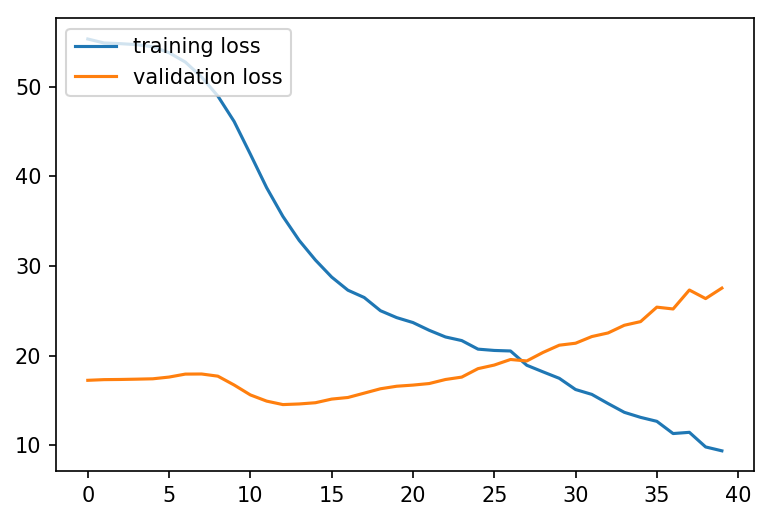

In [28]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

plt.figure()
plt.plot(tr_loss, label='training loss')
plt.plot(te_loss, label='validation loss')
plt.legend(loc='upper left')
plt.show()

### record

In [18]:
# samples = tr_input[0,:,:].numpy()
# for sample in samples:
# #     sample = sample[0,:]
# #     sample = samples[0,0,:]
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
#     ax1.plot(sample)
#     ax2.plot(abs(np.fft.fft(sample)))
#     plt.show()

#     N = 10
#     sample_filtered = np.convolve(sample, np.ones((N,))/N, mode='valid')

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
#     ax1.plot(sample_filtered)
#     ax2.plot(abs(np.fft.fft(sample_filtered)))
#     plt.show()

In [19]:
# # size of moving average filter
# N = 10 
# # downsampling
# Nd = 5
# sample = lowpass_filtering(tr_input[0,0,:].numpy(), N)[::Nd]

# tr_input_filtered = torch.zeros([tr_input.shape[0],tr_input.shape[1],sample.shape[0]])
# te_input_filtered = torch.zeros([te_input.shape[0],te_input.shape[1],sample.shape[0]])

# for idx1, data in enumerate(tr_input):
#     for idx2, channel in enumerate(data):
#         tr_input_filtered[idx1, idx2, :] = torch.from_numpy(lowpass_filtering(channel.numpy(), 10)[::Nd])

# for idx1, data in enumerate(te_input):
#     for idx2, channel in enumerate(data):
#         te_input_filtered[idx1, idx2, :] = torch.from_numpy(lowpass_filtering(channel.numpy(), 10)[::Nd])
# tr_input = tr_input_filtered
# te_input = te_input_filtered

In [20]:
# sample = dc_blocker(tr_input[0,0,:].numpy())

# tr_input_filtered = torch.zeros([tr_input.shape[0],tr_input.shape[1],sample.shape[0]])
# te_input_filtered = torch.zeros([te_input.shape[0],te_input.shape[1],sample.shape[0]])

# for idx1, data in enumerate(tr_input):
#     for idx2, channel in enumerate(data):
#         tr_input_filtered[idx1, idx2, :] = torch.from_numpy(dc_blocker(channel.numpy()))

# for idx1, data in enumerate(te_input):
#     for idx2, channel in enumerate(data):
#         te_input_filtered[idx1, idx2, :] = torch.from_numpy(dc_blocker(channel.numpy()))


# tr_input = tr_input_filtered
# te_input = te_input_filtered

# sample = tr_input[1,6,:].numpy()
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# ax1.plot(sample)
# sample_dc = dc_blocker(sample)
# ax2.plot(sample_dc)
# plt.show()

In [21]:
# sample = tr_input[:,11,:].numpy()
# for channel in sample[0:4]:
# #     plt.plot(channel)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# #     ax1.plot(channel)
#     sample_fft = np.fft.fft(channel)
# #     ax1.plot(abs(sample_fft))
#     ax1.plot(channel)
# #     ax2.plot(np.angle(sample_fft))
#     ax2.plot(abs(np.fft.fft(channel)))

#     plt.show()

In [22]:
# def fft_data(signal, size = 20):
#     sample_fft = np.fft.fft(signal)
#     sample_angle = np.angle(sample_fft)
    
#     return np.append(abs(sample_fft)[0:size],sample_angle[0:size])


# sample = fft_data(tr_input[0,0,:].numpy())

# tr_input_filtered = torch.zeros([tr_input.shape[0],tr_input.shape[1],sample.shape[0]])
# te_input_filtered = torch.zeros([te_input.shape[0],te_input.shape[1],sample.shape[0]])

# for idx1, data in enumerate(tr_input):
#     for idx2, channel in enumerate(data):
#         tr_input_filtered[idx1, idx2, :] = torch.from_numpy(fft_data(channel.numpy()))

# for idx1, data in enumerate(te_input):
#     for idx2, channel in enumerate(data):
#         te_input_filtered[idx1, idx2, :] = torch.from_numpy(fft_data(channel.numpy()))


# tr_input = tr_input_filtered
# te_input = te_input_filtered


In [ ]:
# epoch = 400
# lr = 1e-2


# net = Net(num_channel, signal_len)

# loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# tr_loss_all = []
# te_loss_all = []

# for e in range(0, epoch):
#     tr_loss = 0
#     te_loss = 0
    
#     prediction = net(tr_input)
#     loss = loss_func(prediction, tr_target)
#     tr_loss = loss.data[0]
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     prediction = net(te_input)
#     loss = loss_func(prediction, te_target)
#     te_loss = loss.data[0]
    
#     print('epoch {:d} tr loss {:0.2f} te loss {:0.2f}'.format(e, tr_loss, te_loss))

# num_correct = np.sum((torch.max(F.softmax(model(tr_input), 1), 1)[1] == tr_target).data.numpy())
# print('tr acc = {:0.2f}'.format(num_correct/tr_target.shape[0]))
# num_correct = np.sum((torch.max(F.softmax(model(te_input), 1), 1)[1] == te_target).data.numpy())
# print('te acc = {:0.2f}'.format(num_correct/te_target.shape[0]))
# # num_correct = float(torch.sum(torch.max(F.softmax(net(tr_input), 1), 1)[1] == tr_target).data)
# # print('tr acc = {:0.2f}'.format(num_correct/tr_target.shape[0]))
# # num_correct = float(torch.sum(torch.max(F.softmax(net(te_input), 1), 1)[1] == te_target).data)
# # print('tr acc = {:0.2f}'.format(num_correct/te_target.shape[0]))